In [1]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, f1_score
from tqdm import tqdm
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostClassifier, Pool
import datetime
import warnings

# Suppress PerformanceWarning
warnings.filterwarnings("ignore")

## Load data

Prior to loading the data, we identify and categorize columns with string data types in the dataset. Additionally, it selects columns from the 'V' category, focusing on those that exhibit meaningful relationships with the target variable as revealed through correlation-based exploratory data analysis (EDA). By doing so, the code aims to streamline the dataset to include only the most relevant 'V' columns, optimizing computational efficiency and model performance during subsequent analysis and modeling phases.

In [2]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [3]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('./train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('./train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('./test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('./test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: total: 27.3 s
Wall time: 28.8 s


## Normalizing and converting D columns

After looking at the dataset, we realise that the 'D Columns' represent time intervals relative to a specific past reference point. Our objective is to remove time dependence and convert these 'D Columns' into values that correspond to moments in the past rather than future time intervals. This adjustment ensures that the 'D Columns' no longer exhibit an increasing trend over time because we have normalized it against the effects of time. We achieve this transformation using the formula `D15n = Transaction_Day - D15`, where 'Transaction_Day' is calculated as 'TransactionDT' divided by the number of seconds in a day (24 hours * 60 minutes * 60 seconds). Subsequently, we invert the result by multiplying it by -1.

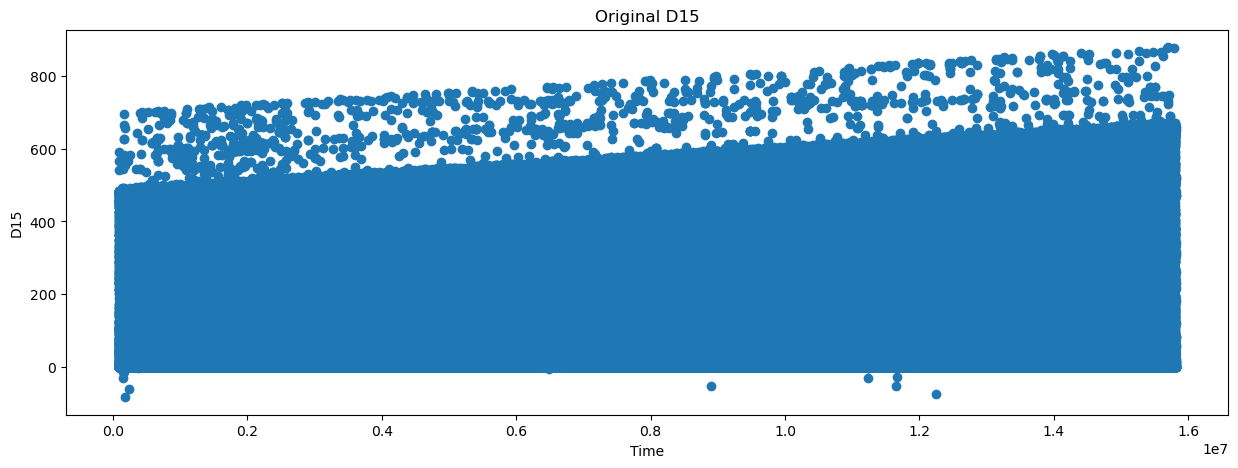

In [4]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

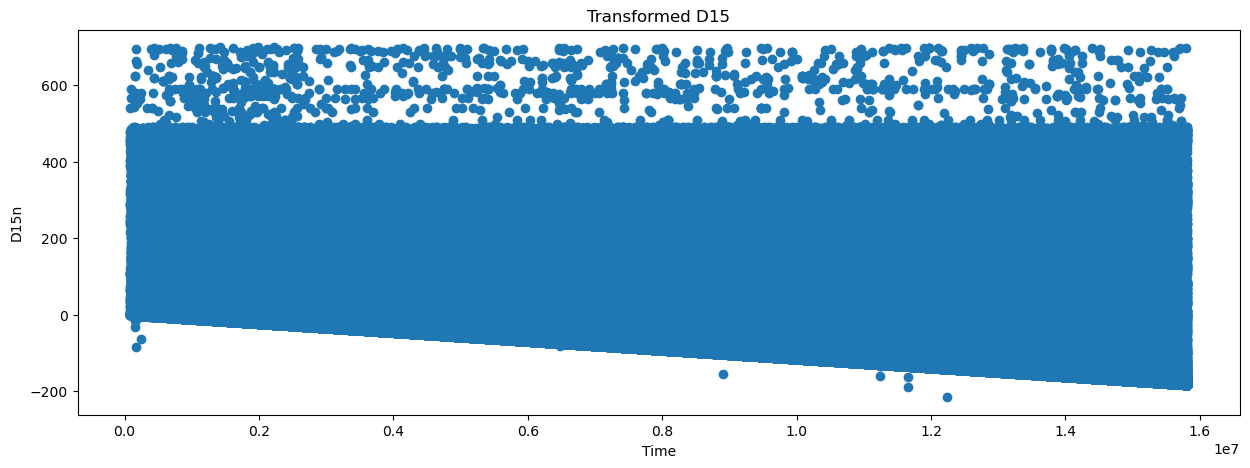

In [5]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: 
        continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 
    
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

## Dataset cleaning and preprocessing

Our next step involves the transformation of categorical variables to integers through encoding, the normalization of numeric columns, and addressing any missing data. Given the substantial size of the dataset, we also prioritize memory optimization by ensuring the usage of compatible data types wherever possible. This multi-faceted data preprocessing process aims to enhance the dataset's suitability for analysis and modeling, considering both its size and the type of data it contains.

In [6]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i, f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (str(X_train[f].dtype) == 'category') or (X_train[f].dtype == 'object'): 
        df_comb = pd.concat([X_train[f], X_test[f]], axis=0)
        df_comb, _ = df_comb.factorize(sort=True)
        if df_comb.max() > 32000:
            print(f, 'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt', 'TransactionDT']:
        mn = np.min((X_train[f].min(), X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1, inplace=True)
        X_test[f].fillna(-1, inplace=True)

CPU times: total: 4.52 s
Wall time: 4.79 s


## Encoding functions

To address categorical variables, we must identify and consider all categorical variables that are present in both the test and train sets. This comprehensive approach ensures that we encode all relevant categorical variables consistently across the entire dataset.

1) `encode_FE` performs frequency encoding after in combines the train and test set. This allows us to see whether the column values are rare or common. For example, we can use this to check which credit cards are used infrequently.

2) `encode_LE` performs label encoding on the categorical features and converts them into integers. We factorize to reduce memory and turn NAN into -1.

3) `encode_AG` creates aggregated features such as the aggregated mean and std dev. This allows for the model to tell if a row has abnormal values compared to the mean value.

4) `encode_CB` combines two columns together into one column.

5) `encode_AG2` creates more aggregated features where it counts how many unique values of one feature within a group.

In [7]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    df1 = df1.copy()
    df2 = df2.copy()
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')
    train_df = train_df.copy()
    test_df = test_df.copy()

# Feature engineering

In this procedure, we brainstorm potential methods to create new features. Subsequently, we assess each newly generated feature's impact on the Area Under the Curve (AUC) metric. If the addition of a feature leads to an increase in AUC, we retain that feature; otherwise, we eliminate it from consideration. This iterative process helps us identify and incorporate features that enhance model performance while disregarding those that do not contribute positively. The below features are the features that we have thought of that increases the AUC score.

In [8]:
%%time

# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: total: 12.6 s
Wall time: 13.6 s


# Feature selection

Above, we added 28 additional features, bringing the total number of columns to 242, including the index. With this substantial number of features, our goal is to identify the pertinent ones that significantly impact our model's performance. Our chosen evaluation metric is AUC. Therefore, we need to systematically evaluate each feature to ensure that it contributes positively to the model.

We will be using data from the first 30 days as train data to train the model, and use data from the last 30 days as test data to test the model. Specifically, we want to confirm that each feature yields an AUC score >0.5 to be considered valuable, if not the feature is not useful as it is worse than random guessing which yields an AUC score of 0.5. Features failing to meet this criterion are considered non-contributory and will be excluded from further consideration.

In [9]:
# Define the start and end timestamps for the first and last months, assuming 30 days in a month
start_timestamp_first_month = X_train['TransactionDT'].min()
end_timestamp_first_month = start_timestamp_first_month + (30 * 24 * 60 * 60)  

start_timestamp_last_month = X_train['TransactionDT'].max() - (30 * 24 * 60 * 60)  
end_timestamp_last_month = X_train['TransactionDT'].max()

# Select rows corresponding to the first month
X_first_month = X_train[(X_train['TransactionDT'] >= start_timestamp_first_month) &
                         (X_train['TransactionDT'] < end_timestamp_first_month)]

# Select rows corresponding to the last month
X_last_month = X_train[(X_train['TransactionDT'] >= start_timestamp_last_month) &
                        (X_train['TransactionDT'] <= end_timestamp_last_month)]

# Extract the indices of rows in X_train that belong to the first month
indices_first_month = (X_train['TransactionDT'] >= start_timestamp_first_month) & (X_train['TransactionDT'] < end_timestamp_first_month)

# Extract the indices of rows in X_train that belong to the last month
indices_last_month = (X_train['TransactionDT'] >= start_timestamp_last_month) & (X_train['TransactionDT'] <= end_timestamp_last_month)

# Use the indices to extract the corresponding y_train entries
y_first_month = y_train[indices_first_month]
y_last_month = y_train[indices_last_month]

In [10]:
%%time
# Create an empty list to store the selected features
selected_features = []

# Define the evaluation threshold (AUC > 0.5)
threshold = 0.5

# Create a tqdm progress bar for the loop
for feature in tqdm(X_train.columns, desc="Processing Features"):
    
    # Train a logistic regression model using only the current feature
    #model = xgb.XGBClassifier()
    model = lgb.LGBMClassifier()
    model.fit(X_first_month[[feature]], y_first_month)
    
    # Predict on the last month of the training data
    y_pred = model.predict_proba(X_last_month[[feature]])[:, 1]
    
    # Calculate AUC for the validation set
    auc = roc_auc_score(y_last_month, y_pred)
    
    # Check if AUC is above the threshold
    if auc > threshold:
        selected_features.append(feature)

Processing Features:   0%|                                                                     | 0/241 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:   0%|▎                                                            | 1/241 [00:00<01:59,  2.01it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:   1%|▊                                                            | 3/241 [00:01<01:20,  2.96it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:   2%|█                                                            | 4/241 [00:01<01:23,  2.85it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:   2%|█▎                                                           | 5/241 [00:01<01:24,  2.81it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:   3%|█▊                                                           | 7/241 [00:02<01:11,  3.26it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:   4%|██▎                                                          | 9/241 [00:02<01:03,  3.66it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:   5%|██▋                                                         | 11/241 [00:03<01:05,  3.53it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:   5%|██▉                                                         | 12/241 [00:03<01:07,  3.38it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:   5%|███▏                                                        | 13/241 [00:04<01:09,  3.27it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:   6%|███▍                                                        | 14/241 [00:04<01:10,  3.21it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:   6%|███▋                                                        | 15/241 [00:04<01:08,  3.30it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:   7%|███▉                                                        | 16/241 [00:05<01:09,  3.24it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:   7%|████▍                                                       | 18/241 [00:05<01:00,  3.71it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:   8%|████▋                                                       | 19/241 [00:06<01:13,  3.03it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:   8%|████▉                                                       | 20/241 [00:06<01:13,  3.00it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:   9%|█████▏                                                      | 21/241 [00:06<01:15,  2.92it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:   9%|█████▍                                                      | 22/241 [00:07<01:18,  2.79it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  10%|█████▋                                                      | 23/241 [00:07<01:25,  2.54it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  10%|█████▉                                                      | 24/241 [00:08<01:28,  2.45it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  10%|██████▏                                                     | 25/241 [00:08<01:33,  2.32it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  11%|██████▍                                                     | 26/241 [00:08<01:29,  2.41it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  11%|██████▋                                                     | 27/241 [00:09<01:26,  2.46it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  12%|██████▉                                                     | 28/241 [00:09<01:22,  2.57it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  12%|███████▏                                                    | 29/241 [00:10<01:20,  2.65it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  12%|███████▍                                                    | 30/241 [00:10<01:18,  2.67it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  13%|███████▋                                                    | 31/241 [00:10<01:16,  2.73it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  13%|███████▉                                                    | 32/241 [00:11<01:13,  2.85it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  14%|████████▏                                                   | 33/241 [00:11<01:13,  2.83it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  14%|████████▍                                                   | 34/241 [00:11<01:10,  2.94it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  15%|████████▋                                                   | 35/241 [00:12<01:07,  3.04it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  15%|████████▉                                                   | 36/241 [00:12<01:04,  3.16it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  15%|█████████▏                                                  | 37/241 [00:12<01:05,  3.11it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  16%|█████████▍                                                  | 38/241 [00:12<01:00,  3.33it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  16%|█████████▋                                                  | 39/241 [00:13<01:03,  3.20it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  17%|█████████▉                                                  | 40/241 [00:13<01:05,  3.06it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  17%|██████████▏                                                 | 41/241 [00:13<01:03,  3.13it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  17%|██████████▍                                                 | 42/241 [00:14<01:02,  3.20it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  18%|██████████▋                                                 | 43/241 [00:14<01:02,  3.15it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  19%|███████████▏                                                | 45/241 [00:15<00:57,  3.42it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  19%|███████████▍                                                | 46/241 [00:15<00:52,  3.74it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  20%|███████████▋                                                | 47/241 [00:15<00:48,  3.96it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  20%|███████████▉                                                | 48/241 [00:15<00:46,  4.11it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  20%|████████████▏                                               | 49/241 [00:15<00:45,  4.25it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  21%|████████████▍                                               | 50/241 [00:16<00:44,  4.30it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  21%|████████████▋                                               | 51/241 [00:16<00:41,  4.53it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  22%|████████████▉                                               | 52/241 [00:16<00:40,  4.62it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Processing Features:  22%|█████████████▏                                              | 53/241 [00:16<00:39,  4.79it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  22%|█████████████▍                                              | 54/241 [00:16<00:38,  4.89it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  23%|█████████████▋                                              | 55/241 [00:17<00:39,  4.74it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  24%|██████████████▏                                             | 57/241 [00:17<00:40,  4.58it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  24%|██████████████▍                                             | 58/241 [00:17<00:40,  4.57it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  24%|██████████████▋                                             | 59/241 [00:18<00:40,  4.53it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  25%|███████████████▏                                            | 61/241 [00:18<00:40,  4.48it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  26%|███████████████▍                                            | 62/241 [00:18<00:40,  4.37it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  26%|███████████████▋                                            | 63/241 [00:19<00:41,  4.27it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  27%|███████████████▉                                            | 64/241 [00:19<00:42,  4.18it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  27%|████████████████▍                                           | 66/241 [00:19<00:40,  4.35it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  28%|████████████████▋                                           | 67/241 [00:19<00:40,  4.34it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  28%|████████████████▉                                           | 68/241 [00:20<00:39,  4.34it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Processing Features:  29%|█████████████████▏                                          | 69/241 [00:20<00:40,  4.23it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  29%|█████████████████▋                                          | 71/241 [00:20<00:39,  4.29it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  30%|█████████████████▉                                          | 72/241 [00:21<00:40,  4.17it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  30%|██████████████████▏                                         | 73/241 [00:21<00:39,  4.24it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  31%|██████████████████▍                                         | 74/241 [00:21<00:39,  4.28it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  32%|██████████████████▉                                         | 76/241 [00:22<00:41,  3.93it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  32%|███████████████████▍                                        | 78/241 [00:22<00:40,  4.04it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  33%|███████████████████▋                                        | 79/241 [00:22<00:38,  4.25it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  33%|███████████████████▉                                        | 80/241 [00:23<00:38,  4.19it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  34%|████████████████████▏                                       | 81/241 [00:23<00:36,  4.39it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  34%|████████████████████▍                                       | 82/241 [00:23<00:36,  4.32it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  35%|████████████████████▉                                       | 84/241 [00:24<00:37,  4.21it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  36%|█████████████████████▍                                      | 86/241 [00:24<00:37,  4.15it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  37%|█████████████████████▉                                      | 88/241 [00:25<00:35,  4.28it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  37%|██████████████████████▏                                     | 89/241 [00:25<00:33,  4.49it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  37%|██████████████████████▍                                     | 90/241 [00:25<00:33,  4.48it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  38%|██████████████████████▋                                     | 91/241 [00:25<00:28,  5.25it/s]

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

Processing Features:  38%|██████████████████████▉                                     | 92/241 [00:25<00:28,  5.20it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  39%|███████████████████████▍                                    | 94/241 [00:26<00:27,  5.36it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  39%|███████████████████████▋                                    | 95/241 [00:26<00:26,  5.56it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  40%|███████████████████████▉                                    | 96/241 [00:26<00:25,  5.65it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  41%|████████████████████████▍                                   | 98/241 [00:26<00:25,  5.54it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  41%|████████████████████████▋                                   | 99/241 [00:27<00:26,  5.43it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  41%|████████████████████████▍                                  | 100/241 [00:27<00:34,  4.13it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  42%|████████████████████████▋                                  | 101/241 [00:27<00:40,  3.47it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  42%|████████████████████████▉                                  | 102/241 [00:28<00:43,  3.22it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  43%|█████████████████████████▍                                 | 104/241 [00:28<00:42,  3.19it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  44%|█████████████████████████▋                                 | 105/241 [00:29<00:39,  3.48it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  44%|█████████████████████████▉                                 | 106/241 [00:29<00:35,  3.79it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  45%|██████████████████████████▍                                | 108/241 [00:29<00:33,  4.03it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  45%|██████████████████████████▋                                | 109/241 [00:30<00:35,  3.72it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  46%|██████████████████████████▉                                | 110/241 [00:30<00:37,  3.48it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  46%|███████████████████████████▏                               | 111/241 [00:30<00:37,  3.44it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  47%|███████████████████████████▋                               | 113/241 [00:31<00:35,  3.65it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  48%|████████████████████████████▏                              | 115/241 [00:31<00:32,  3.92it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  48%|████████████████████████████▍                              | 116/241 [00:31<00:30,  4.15it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  49%|████████████████████████████▋                              | 117/241 [00:32<00:29,  4.14it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  49%|████████████████████████████▉                              | 118/241 [00:32<00:34,  3.59it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  49%|█████████████████████████████▏                             | 119/241 [00:32<00:35,  3.42it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  50%|█████████████████████████████▌                             | 121/241 [00:33<00:33,  3.59it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  51%|██████████████████████████████                             | 123/241 [00:33<00:31,  3.69it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  51%|██████████████████████████████▎                            | 124/241 [00:34<00:30,  3.80it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  52%|██████████████████████████████▌                            | 125/241 [00:34<00:34,  3.40it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  52%|██████████████████████████████▊                            | 126/241 [00:34<00:39,  2.94it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  53%|███████████████████████████████                            | 127/241 [00:35<00:41,  2.74it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  53%|███████████████████████████████▎                           | 128/241 [00:35<00:43,  2.62it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  54%|███████████████████████████████▌                           | 129/241 [00:36<00:43,  2.57it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  54%|███████████████████████████████▊                           | 130/241 [00:36<00:45,  2.44it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 71
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  55%|████████████████████████████████▎                          | 132/241 [00:37<00:37,  2.93it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  55%|████████████████████████████████▌                          | 133/241 [00:37<00:34,  3.16it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  56%|████████████████████████████████▊                          | 134/241 [00:37<00:31,  3.42it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  56%|█████████████████████████████████▎                         | 136/241 [00:38<00:28,  3.73it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  57%|█████████████████████████████████▌                         | 137/241 [00:38<00:27,  3.85it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  57%|█████████████████████████████████▊                         | 138/241 [00:38<00:26,  3.82it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  58%|██████████████████████████████████▎                        | 140/241 [00:39<00:27,  3.72it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  59%|██████████████████████████████████▌                        | 141/241 [00:39<00:25,  3.86it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  59%|██████████████████████████████████▊                        | 142/241 [00:39<00:23,  4.17it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  60%|███████████████████████████████████▎                       | 144/241 [00:40<00:23,  4.21it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  61%|███████████████████████████████████▋                       | 146/241 [00:40<00:23,  4.02it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  61%|███████████████████████████████████▉                       | 147/241 [00:40<00:23,  4.09it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  61%|████████████████████████████████████▏                      | 148/241 [00:41<00:22,  4.20it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  62%|████████████████████████████████████▍                      | 149/241 [00:41<00:22,  4.01it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  62%|████████████████████████████████████▋                      | 150/241 [00:41<00:25,  3.58it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  63%|████████████████████████████████████▉                      | 151/241 [00:42<00:29,  3.09it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  63%|█████████████████████████████████████▏                     | 152/241 [00:42<00:31,  2.83it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  63%|█████████████████████████████████████▍                     | 153/241 [00:43<00:33,  2.66it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  64%|█████████████████████████████████████▋                     | 154/241 [00:43<00:34,  2.55it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  65%|██████████████████████████████████████▏                    | 156/241 [00:44<00:29,  2.92it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  66%|██████████████████████████████████████▋                    | 158/241 [00:44<00:23,  3.57it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  66%|███████████████████████████████████████▏                   | 160/241 [00:45<00:20,  4.05it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  67%|███████████████████████████████████████▍                   | 161/241 [00:45<00:18,  4.38it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  67%|███████████████████████████████████████▋                   | 162/241 [00:45<00:19,  4.01it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Processing Features:  68%|███████████████████████████████████████▉                   | 163/241 [00:45<00:20,  3.81it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  68%|████████████████████████████████████████▍                  | 165/241 [00:46<00:18,  4.01it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  69%|████████████████████████████████████████▋                  | 166/241 [00:46<00:17,  4.38it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  70%|█████████████████████████████████████████▏                 | 168/241 [00:46<00:14,  4.88it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training

Processing Features:  70%|█████████████████████████████████████████▎                 | 169/241 [00:47<00:18,  3.86it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  71%|█████████████████████████████████████████▌                 | 170/241 [00:47<00:20,  3.38it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  71%|█████████████████████████████████████████▊                 | 171/241 [00:48<00:23,  3.02it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  71%|██████████████████████████████████████████                 | 172/241 [00:48<00:22,  3.02it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  72%|██████████████████████████████████████████▎                | 173/241 [00:48<00:22,  2.98it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  72%|██████████████████████████████████████████▌                | 174/241 [00:49<00:21,  3.18it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  73%|███████████████████████████████████████████                | 176/241 [00:49<00:19,  3.40it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  73%|███████████████████████████████████████████▎               | 177/241 [00:49<00:17,  3.61it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  74%|███████████████████████████████████████████▌               | 178/241 [00:50<00:18,  3.49it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  74%|███████████████████████████████████████████▊               | 179/241 [00:50<00:17,  3.48it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  75%|████████████████████████████████████████████               | 180/241 [00:50<00:18,  3.36it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  75%|████████████████████████████████████████████▎              | 181/241 [00:51<00:17,  3.42it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  76%|████████████████████████████████████████████▊              | 183/241 [00:51<00:15,  3.69it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  77%|█████████████████████████████████████████████▎             | 185/241 [00:52<00:14,  3.76it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  78%|█████████████████████████████████████████████▊             | 187/241 [00:52<00:14,  3.76it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  78%|██████████████████████████████████████████████             | 188/241 [00:52<00:13,  3.88it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  78%|██████████████████████████████████████████████▎            | 189/241 [00:53<00:12,  4.06it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  79%|██████████████████████████████████████████████▌            | 190/241 [00:53<00:12,  3.96it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  79%|██████████████████████████████████████████████▊            | 191/241 [00:53<00:12,  3.87it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  80%|███████████████████████████████████████████████            | 192/241 [00:53<00:14,  3.42it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  80%|███████████████████████████████████████████████▏           | 193/241 [00:54<00:14,  3.29it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Processing Features:  81%|███████████████████████████████████████████████▋           | 195/241 [00:54<00:12,  3.78it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  81%|███████████████████████████████████████████████▉           | 196/241 [00:54<00:10,  4.09it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Processing Features:  82%|████████████████████████████████████████████████▏          | 197/241 [00:55<00:10,  4.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  82%|████████████████████████████████████████████████▍          | 198/241 [00:55<00:10,  4.12it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  83%|████████████████████████████████████████████████▉          | 200/241 [00:55<00:09,  4.36it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  83%|█████████████████████████████████████████████████▏         | 201/241 [00:56<00:09,  4.44it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  84%|█████████████████████████████████████████████████▍         | 202/241 [00:56<00:08,  4.56it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Processing Features:  84%|█████████████████████████████████████████████████▋         | 203/241 [00:56<00:09,  4.14it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  85%|██████████████████████████████████████████████████▏        | 205/241 [00:57<00:08,  4.02it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  86%|██████████████████████████████████████████████████▋        | 207/241 [00:57<00:08,  4.05it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  86%|██████████████████████████████████████████████████▉        | 208/241 [00:57<00:07,  4.21it/s]

[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Processing Features:  87%|███████████████████████████████████████████████████▏       | 209/241 [00:58<00:07,  4.42it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

Processing Features:  87%|███████████████████████████████████████████████████▍       | 210/241 [00:58<00:06,  4.54it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  88%|███████████████████████████████████████████████████▋       | 211/241 [00:58<00:06,  4.56it/s]

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Processing Features:  88%|███████████████████████████████████████████████████▉       | 212/241 [00:58<00:06,  4.49it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

Processing Features:  88%|████████████████████████████████████████████████████▏      | 213/241 [00:59<00:07,  3.79it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  89%|████████████████████████████████████████████████████▍      | 214/241 [00:59<00:08,  3.37it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  89%|████████████████████████████████████████████████████▋      | 215/241 [00:59<00:08,  3.21it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  90%|████████████████████████████████████████████████████▉      | 216/241 [01:00<00:08,  3.00it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  90%|█████████████████████████████████████████████████████      | 217/241 [01:00<00:08,  2.93it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  90%|█████████████████████████████████████████████████████▎     | 218/241 [01:00<00:07,  3.08it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

Processing Features:  91%|█████████████████████████████████████████████████████▌     | 219/241 [01:01<00:06,  3.14it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  91%|█████████████████████████████████████████████████████▊     | 220/241 [01:01<00:07,  2.94it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  92%|██████████████████████████████████████████████████████     | 221/241 [01:01<00:07,  2.85it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 246
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  92%|██████████████████████████████████████████████████████▎    | 222/241 [01:02<00:06,  2.74it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  93%|██████████████████████████████████████████████████████▌    | 223/241 [01:02<00:06,  2.75it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  93%|██████████████████████████████████████████████████████▊    | 224/241 [01:03<00:06,  2.73it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  93%|███████████████████████████████████████████████████████    | 225/241 [01:03<00:05,  2.72it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  94%|███████████████████████████████████████████████████████▎   | 226/241 [01:03<00:05,  2.66it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  94%|███████████████████████████████████████████████████████▌   | 227/241 [01:04<00:05,  2.63it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  95%|███████████████████████████████████████████████████████▊   | 228/241 [01:04<00:05,  2.59it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  95%|████████████████████████████████████████████████████████   | 229/241 [01:04<00:04,  2.59it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  95%|████████████████████████████████████████████████████████▎  | 230/241 [01:05<00:04,  2.58it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  96%|████████████████████████████████████████████████████████▌  | 231/241 [01:05<00:03,  2.66it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  96%|████████████████████████████████████████████████████████▊  | 232/241 [01:06<00:03,  2.66it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  97%|█████████████████████████████████████████████████████████  | 233/241 [01:06<00:03,  2.65it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  97%|█████████████████████████████████████████████████████████▎ | 234/241 [01:06<00:02,  2.65it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 254
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  98%|█████████████████████████████████████████████████████████▌ | 235/241 [01:07<00:02,  2.65it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  98%|█████████████████████████████████████████████████████████▊ | 236/241 [01:07<00:01,  2.63it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  98%|██████████████████████████████████████████████████████████ | 237/241 [01:08<00:01,  2.61it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  99%|██████████████████████████████████████████████████████████▎| 238/241 [01:08<00:01,  2.60it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features:  99%|██████████████████████████████████████████████████████████▌| 239/241 [01:08<00:00,  2.60it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features: 100%|██████████████████████████████████████████████████████████▊| 240/241 [01:09<00:00,  2.62it/s]

[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654


Processing Features: 100%|███████████████████████████████████████████████████████████| 241/241 [01:09<00:00,  3.47it/s]

CPU times: total: 6min 9s
Wall time: 1min 9s


In [11]:
print('Following',len(X_train.columns) - len(selected_features),'features removed:')
print(np.array(set(X_train.columns) - set(selected_features)))
print('#'*70)
print('Following',len(selected_features),'features selected:')
print(np.array(selected_features))

Following 36 features removed:
{'V310', 'id_31', 'V56', 'V142', 'V286', 'V89', 'V20', 'V27', 'V309', 'V305', 'V26', 'V62', 'V67', 'V162', 'V138', 'id_34', 'V289', 'V297', 'id_08', 'V14', 'V314', 'TransactionDT', 'id_38', 'id_26', 'V285', 'V107', 'id_21', 'V65', 'id_14', 'id_22', 'card4', 'V68', 'id_32', 'V160', 'V88', 'id_07'}
######################################################################
Following 205 features selected:
['TransactionAmt' 'ProductCD' 'card1' 'card2' 'card3' 'card5' 'card6'
 'addr1' 'addr2' 'dist1' 'dist2' 'P_emaildomain' 'R_emaildomain' 'C1' 'C2'
 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13' 'C14' 'D1'
 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'D8' 'D9' 'D10' 'D11' 'D12' 'D13' 'D14'
 'D15' 'M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'M8' 'M9' 'V1' 'V3' 'V4' 'V6'
 'V8' 'V11' 'V13' 'V17' 'V23' 'V30' 'V36' 'V37' 'V40' 'V41' 'V44' 'V47'
 'V48' 'V54' 'V59' 'V70' 'V76' 'V78' 'V80' 'V82' 'V86' 'V91' 'V108' 'V111'
 'V115' 'V117' 'V120' 'V121' 'V123' 'V124' 'V127' 'V129' 'V13

## Local validation 

We conduct a train-test split, where our model is trained on the first 75% of the dataset and assessed on the remaining 25%. In our local validation, the model achieved an AUC of 0.9304.

In [12]:
# train split local validation
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# MODEL SELECTION RUN

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, f1_score

In [21]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, roc_auc_score, recall_score

# Decision Tree
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train.loc[idxT, selected_features], y_train[idxT])
dt_preds_proba = clf_dt.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
dt_preds = (dt_preds_proba > 0.5).astype(int)

# Metrics
dt_auc = roc_auc_score(y_train[idxV], dt_preds_proba)
dt_precision = precision_score(y_train[idxV], dt_preds)
dt_accuracy = accuracy_score(y_train[idxV], dt_preds)
dt_f1 = f1_score(y_train[idxV], dt_preds)
dt_recall = recall_score(y_train[idxV], dt_preds)

# Print the metrics including recall
print(f"Decision Tree Metrics -> AUC: {dt_auc:.4f}, Precision: {dt_precision:.4f}, Accuracy: {dt_accuracy:.4f}, F1-Score: {dt_f1:.4f}, Recall: {dt_recall:.4f}")

Decision Tree Metrics -> AUC: 0.6966, Precision: 0.2545, Accuracy: 0.9362, F1-Score: 0.3222, Recall: 0.4392


In [22]:
# Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train.loc[idxT, selected_features], y_train[idxT])
rf_preds_proba = clf_rf.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
rf_preds = (rf_preds_proba > 0.5).astype(int)

# Metrics
rf_auc = roc_auc_score(y_train[idxV], rf_preds_proba)
rf_precision = precision_score(y_train[idxV], rf_preds)
rf_accuracy = accuracy_score(y_train[idxV], rf_preds)
rf_f1 = f1_score(y_train[idxV], rf_preds)
rf_recall = recall_score(y_train[idxV], rf_preds)

# Print the metrics including recall
print(f"Random Forest Metrics -> AUC: {rf_auc:.4f}, Precision: {rf_precision:.4f}, Accuracy: {rf_accuracy:.4f}, F1-Score: {rf_f1:.4f}, Recall: {rf_recall:.4f}")


Random Forest Metrics -> AUC: 0.9125, Precision: 0.8575, Accuracy: 0.9751, F1-Score: 0.4807, Recall: 0.3339


In [24]:
# XGBoost
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf_xgb.fit(X_train.loc[idxT, selected_features], y_train[idxT])
xgb_preds_proba = clf_xgb.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
xgb_preds = (xgb_preds_proba > 0.5).astype(int)

# Metrics
xgb_auc = roc_auc_score(y_train[idxV], xgb_preds_proba)
xgb_precision = precision_score(y_train[idxV], xgb_preds)
xgb_accuracy = accuracy_score(y_train[idxV], xgb_preds)
xgb_f1 = f1_score(y_train[idxV], xgb_preds)
xgb_recall = recall_score(y_train[idxV], xgb_preds)

# Print the metrics including recall
print(f"XGBoost Metrics -> AUC: {xgb_auc:.4f}, Precision: {xgb_precision:.4f}, Accuracy: {xgb_accuracy:.4f}, F1-Score: {xgb_f1:.4f}, Recall: {xgb_recall:.4f}")

XGBoost Metrics -> AUC: 0.9133, Precision: 0.7832, Accuracy: 0.9748, F1-Score: 0.5049, Recall: 0.3725


In [23]:
# CatBoost
clf_cat = CatBoostClassifier(verbose=0, random_state=42)
clf_cat.fit(X_train.loc[idxT, selected_features], y_train[idxT])
cat_preds_proba = clf_cat.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
cat_preds = (cat_preds_proba > 0.5).astype(int)

# Metrics
cat_auc = roc_auc_score(y_train[idxV], cat_preds_proba)
cat_precision = precision_score(y_train[idxV], cat_preds)
cat_accuracy = accuracy_score(y_train[idxV], cat_preds)
cat_f1 = f1_score(y_train[idxV], cat_preds)
cat_recall = recall_score(y_train[idxV], cat_preds)

# Print the metrics including recall
print(f"CatBoost Metrics -> AUC: {cat_auc:.4f}, Precision: {cat_precision:.4f}, Accuracy: {cat_accuracy:.4f}, F1-Score: {cat_f1:.4f}, Recall: {cat_recall:.4f}")

CatBoost Metrics -> AUC: 0.9114, Precision: 0.8118, Accuracy: 0.9751, F1-Score: 0.5039, Recall: 0.3653


In [26]:
# LightGBM
clf_lgbm = lgb.LGBMClassifier(random_state=42)
clf_lgbm.fit(X_train.loc[idxT, selected_features], y_train[idxT])
lgbm_preds_proba = clf_lgbm.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
lgbm_preds = (lgbm_preds_proba > 0.5).astype(int)

# Metrics
lgbm_auc = roc_auc_score(y_train[idxV], lgbm_preds_proba)
lgbm_precision = precision_score(y_train[idxV], lgbm_preds)
lgbm_accuracy = accuracy_score(y_train[idxV], lgbm_preds)
lgbm_f1 = f1_score(y_train[idxV], lgbm_preds)
lgbm_recall = recall_score(y_train[idxV], lgbm_preds)

# Print the metrics including recall
print(f"LightGBM Metrics -> AUC: {lgbm_auc:.4f}, Precision: {lgbm_precision:.4f}, Accuracy: {lgbm_accuracy:.4f}, F1-Score: {lgbm_f1:.4f}, Recall: {lgbm_recall:.4f}")

[LightGBM] [Info] Number of positive: 15563, number of negative: 427342
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.272791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23675
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 205
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035138 -> initscore=-3.312688
[LightGBM] [Info] Start training from score -3.312688
LightGBM Metrics -> AUC: 0.9111, Precision: 0.7468, Accuracy: 0.9733, F1-Score: 0.4706, Recall: 0.3435


In [25]:
# Logistic Regression
clf_lr = LogisticRegression(random_state=42)  # Increased max_iter for convergence
clf_lr.fit(X_train.loc[idxT, selected_features], y_train[idxT])
lr_preds_proba = clf_lr.predict_proba(X_train.loc[idxV, selected_features])[:, 1]
lr_preds = (lr_preds_proba > 0.5).astype(int)

# Metrics
lr_auc = roc_auc_score(y_train[idxV], lr_preds_proba)
lr_precision = precision_score(y_train[idxV], lr_preds)
lr_accuracy = accuracy_score(y_train[idxV], lr_preds)
lr_f1 = f1_score(y_train[idxV], lr_preds)
lr_recall = recall_score(y_train[idxV], lr_preds)

# Print the metrics including recall
print(f"Logistic Regression Metrics -> AUC: {lr_auc:.4f}, Precision: {lr_precision:.4f}, Accuracy: {lr_accuracy:.4f}, F1-Score: {lr_f1:.4f}, Recall: {lr_recall:.4f}")


Logistic Regression Metrics -> AUC: 0.7299, Precision: 0.0000, Accuracy: 0.9652, F1-Score: 0.0000, Recall: 0.0000
